# Data Science | Lab: Image Processing


In [49]:
#%pip install opencv-contrib-python
#%pip install imutils
#%pip install tqdm

import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from scipy.cluster.vq import vq
from sklearn.neighbors import NearestCentroid
from sklearn.metrics import accuracy_score, confusion_matrix
import imutils
import cv2
from tqdm import tqdm
from sklearn.cluster import KMeans
import random

In [50]:
# Define the image source folder
directory = "101_ObjectCategories"
# Choose three different classes individually
use_classes = [
    "butterfly",
    "scorpion",
    "kangaroo",
    "helicopter",
    "sunflower"
]

In [51]:
for root, _, files in os.walk(directory):
    n_files = len(files)
    subdir = root.split('/')[-1]
    if n_files >= 80 and n_files <= 120:
        print(f"{subdir} [{n_files}]")

hawksbill [100]
butterfly [91]
chandelier [107]
grand_piano [99]
trilobite [86]
scorpion [84]
revolver [82]
menorah [87]
helicopter [88]
starfish [86]
ketch [114]
ibis [80]
kangaroo [86]
brain [98]
buddha [85]
laptop [81]
ewer [85]
sunflower [85]


In [52]:
X_paths = []
y = []
for root, _, files in os.walk(directory):
    class_name = os.path.basename(root)  # Get last folder name
    if class_name in use_classes:
        for file in files:
            file_path = os.path.join(root, file)  # Use os.path.join() for OS-independence
            X_paths.append(file_path)
            y.append(class_name)



### Train/Test split
- Perform a train/test split of the dataset (``X`` being image paths, ``y`` being corresponding labels) you constructed.
- Use 80% of data to train the model.
- Be sure to use stratified sampling since not all categories consist of equal number of images.

In [53]:
X_train, X_test, y_train, y_test = train_test_split(
    X_paths,
    y,
    train_size=0.8,
    stratify=y
)

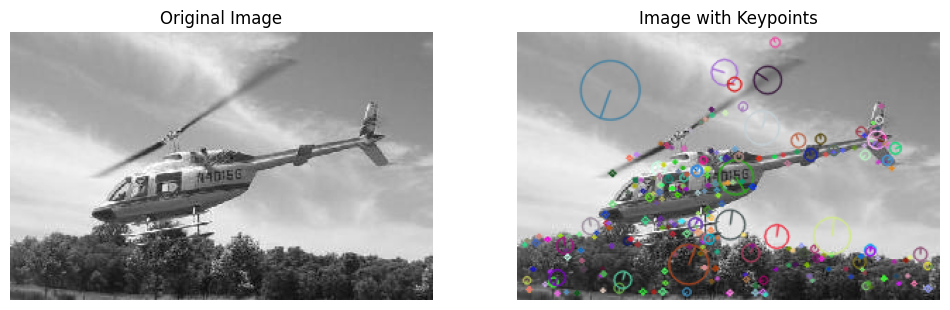

In [54]:
img = cv2.imread(X_train[0], cv2.IMREAD_GRAYSCALE)

sift = cv2.SIFT_create()

keypoints, descriptors = sift.detectAndCompute(img, None)

img_with_keypoints = cv2.drawKeypoints(img, keypoints, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].imshow(img, cmap='gray')
axes[0].set_title("Original Image")
axes[0].axis("off")

axes[1].imshow(img_with_keypoints, cmap='gray')
axes[1].set_title("Image with Keypoints")
axes[1].axis("off")

plt.show()


In [55]:
def extract_features(image_paths):
    desc_list = []
    sift = cv2.SIFT_create()
    for p in tqdm(image_paths, desc="Processing image paths"):
        _, desc = sift.detectAndCompute(
            cv2.imread(p, cv2.IMREAD_GRAYSCALE),
            mask=None
        )
        desc_list.append(desc)
    return desc_list

In [56]:
train_desc_list = extract_features(X_train)
test_desc_list = extract_features(X_test)

Processing image paths: 100%|██████████| 87/87 [00:00<00:00, 159.22it/s]


In [57]:
train_descriptors = np.vstack(train_desc_list)

In [58]:
def compute_feature_histogram(_model, _desc_list, _k, normalisation):
    # Compute feature histogram
    _bovw_features = np.zeros((len(_desc_list), _k), "float32")
    for i, descr in enumerate(_desc_list):
        labels = _model.predict(descr)
        if normalisation:
            img_hist, _ = np.histogram(labels, density=True, bins=_k)
            _bovw_features[i] = img_hist
        else:
            img_hist, _ = np.histogram(labels, density=False, bins=_k)
            _bovw_features[i] = img_hist
    return _bovw_features

## Homework Assignment

Extend your code to include the following:
1. Extend your dataset to use 5 different individually chosen categories of images.
2. Set up a grid search for at least three different ``k`` for K-Means and two different distance ``metric``s for MinDist.
3. Evaluate the grid with 3-fold (stratified) cross validation with ``accuracy`` as the scoring method.
4. Check if histogram normalization has an influence on your results by including it as an option in your grid search.
5. Plot the confusion matrix for the test dataset using the best setting according to the grid search.
6. Document your findings (see final comment in section Moodle Upload on the topics to include in your findings).


## Moodle Upload
This is an **indivdual** assignment, meaning that you are graded individually. If you have collaborated with colleagues during the lab, make sure to state **all** of their names at the beginning of the document. The final document **must** exhibit individual efforts (structure, variable settings, reasoning, interpretation) despite some inherent similarities. 

Upload your notebook as ``firstname_lastname_ip.html`` to Moodle. 

Make sure to consider the following:
* Have all your import statements in one single cell at the top of the notebook.
* Remove unnecessary code.
* Include a markdown cell at the end where you:
    * give a short overview of what your notebook is about
    * be sure to describe BOVW in your own words: Which steps are necessary? How does it relate to the BoW-concept from NLP? What are "words" and "documents" in this context?
    * describe and interpret your settings and justify your choices
    * analyze the final/best results

In [59]:
param_grid = {
    'k': [50, 70, 90, 100, 110, 130, 150],
    'metric': ["manhattan", "euclidean"],
    'normalize': [False, True]
}

best_params = None
best_score = 0

norm_accuracies = []
non_norm_accuracies = []

for k in param_grid['k']:
    kmeans = KMeans(n_clusters=k, n_init=5, max_iter=300, random_state=42)
    kmeans.fit(train_descriptors)
    
    for normalize in param_grid['normalize']:
        features = compute_feature_histogram(kmeans, train_desc_list, k, normalize)
        
        for metric in param_grid['metric']:
            clf = NearestCentroid(metric=metric)
            skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
            scores = []
            
            for train_idx, val_idx in skf.split(features, y_train):
                clf.fit(features[train_idx], np.array(y_train)[train_idx])
                preds = clf.predict(features[val_idx])
                scores.append(accuracy_score(np.array(y_train)[val_idx], preds))
                
            avg_accuracy = np.mean(scores)
            print(f"K={k}, Metric={metric}, Normalize={normalize}, Accuracy={avg_accuracy:.4f}")
            
            if normalize:
                norm_accuracies.append(avg_accuracy)
            else:
                non_norm_accuracies.append(avg_accuracy)
            
            if avg_accuracy > best_score:
                best_score = avg_accuracy
                best_params = {"k": k, "metric": metric, "normalize": normalize}
                best_kmeans = kmeans

avg_norm_accuracy = np.mean(norm_accuracies) if norm_accuracies else 0
avg_non_norm_accuracy = np.mean(non_norm_accuracies) if non_norm_accuracies else 0

print("\nBest Parameters:", best_params)


K=50, Metric=manhattan, Normalize=False, Accuracy=0.4381
K=50, Metric=euclidean, Normalize=False, Accuracy=0.4438
K=50, Metric=manhattan, Normalize=True, Accuracy=0.4553
K=50, Metric=euclidean, Normalize=True, Accuracy=0.4639
K=70, Metric=manhattan, Normalize=False, Accuracy=0.4410
K=70, Metric=euclidean, Normalize=False, Accuracy=0.4468
K=70, Metric=manhattan, Normalize=True, Accuracy=0.4899
K=70, Metric=euclidean, Normalize=True, Accuracy=0.4784
K=90, Metric=manhattan, Normalize=False, Accuracy=0.4611
K=90, Metric=euclidean, Normalize=False, Accuracy=0.4553
K=90, Metric=manhattan, Normalize=True, Accuracy=0.4986
K=90, Metric=euclidean, Normalize=True, Accuracy=0.4841
K=100, Metric=manhattan, Normalize=False, Accuracy=0.4150
K=100, Metric=euclidean, Normalize=False, Accuracy=0.4352
K=100, Metric=manhattan, Normalize=True, Accuracy=0.4755
K=100, Metric=euclidean, Normalize=True, Accuracy=0.4611
K=110, Metric=manhattan, Normalize=False, Accuracy=0.4006
K=110, Metric=euclidean, Normalize

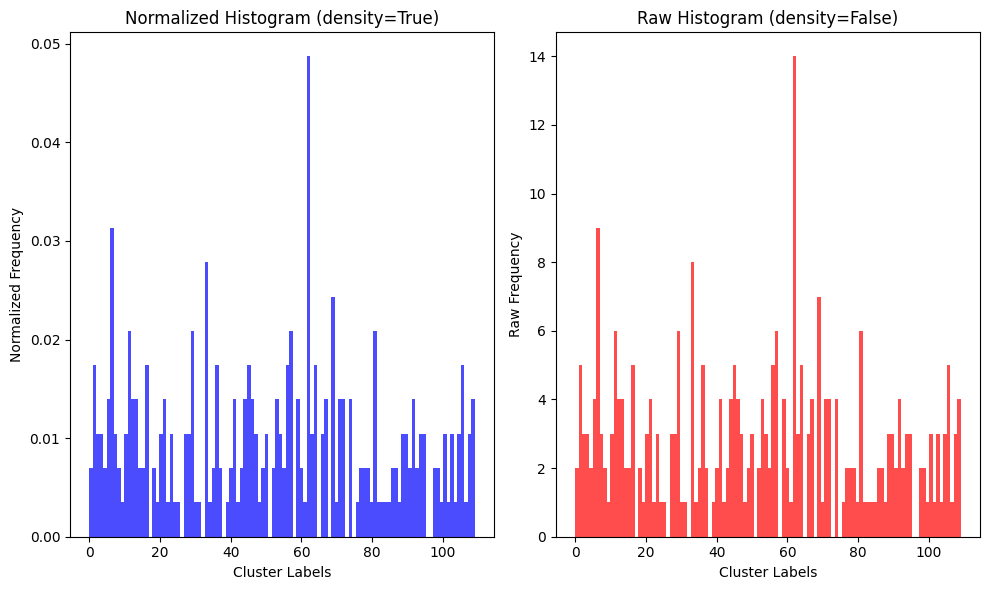

In [60]:
labels = best_kmeans.predict(train_desc_list[0])

fig, axes = plt.subplots(1, 2, figsize=(10, 6))

axes[0].hist(labels, bins=best_params["k"], density=True, color='blue', alpha=0.7)
axes[0].set_title("Normalized Histogram (density=True)")
axes[0].set_xlabel("Cluster Labels")
axes[0].set_ylabel("Normalized Frequency")

axes[1].hist(labels, bins=best_params["k"], density=False, color='red', alpha=0.7)
axes[1].set_title("Raw Histogram (density=False)")
axes[1].set_xlabel("Cluster Labels")
axes[1].set_ylabel("Raw Frequency")

plt.tight_layout()
plt.show()


Average Accuracy with Normalization: 0.4736
Average Accuracy without Normalization: 0.4350


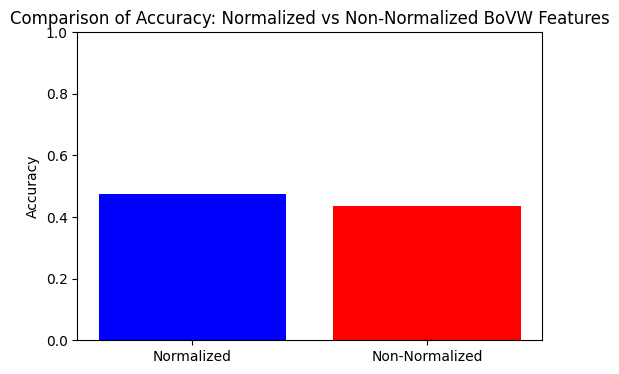

In [61]:
print("\nAverage Accuracy with Normalization: {:.4f}".format(avg_norm_accuracy))
print("Average Accuracy without Normalization: {:.4f}".format(avg_non_norm_accuracy))

plt.figure(figsize=(6, 4))
plt.bar(['Normalized', 'Non-Normalized'], [avg_norm_accuracy, avg_non_norm_accuracy],
        color=['blue', 'red'])
plt.ylim(0, 1)
plt.ylabel("Accuracy")
plt.title("Comparison of Accuracy: Normalized vs Non-Normalized BoVW Features")
plt.show()



Final Test Accuracy: 0.4368


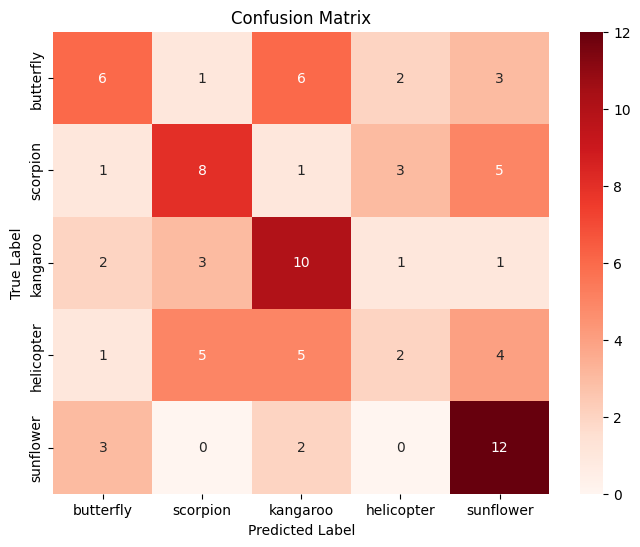

In [62]:
best_kmeans.fit(train_descriptors) 
train_bovw_features = compute_feature_histogram(best_kmeans, train_desc_list, best_params["k"], best_params["normalize"])
test_bovw_features = compute_feature_histogram(best_kmeans, test_desc_list, best_params["k"], best_params["normalize"])

clf = NearestCentroid(metric=best_params["metric"])
clf.fit(train_bovw_features, y_train)
y_pred = clf.predict(test_bovw_features)

final_accuracy = accuracy_score(y_test, y_pred)
print(f"\nFinal Test Accuracy: {final_accuracy:.4f}")

conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
seaborn.heatmap(conf_matrix, annot=True, fmt="d", cmap="Reds", xticklabels=use_classes, yticklabels=use_classes)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# **Final Summary and Findings**

This notebook focuses on implementing the **Bag of Visual Words (BoVW)** approach for image classification. The goal was to represent images using a set of local features and then classify them into different categories. The process involved extracting key features from images, clustering them into a vocabulary, and then training a classifier based on these feature representations.

## **Understanding Bag of Visual Words (BoVW)**
The **Bag of Visual Words (BoVW)** is inspired by the **Bag of Words (BoW)** concept from NLP. In BoW, text documents are represented as histograms of word frequencies, where the "words" come from a predefined vocabulary. In comparison, images in BoVW are represented as histograms of visual features.

### **Steps in BoVW:**
1. **Feature Extraction:** First, we extract **local features** from images. In this project, I used **SIFT (Scale-Invariant Feature Transform)**.
2. **Clustering (Creating the Vocabulary):** Since individual features are too detailed to be used directly, we group similar features into **"visual words"** using **K-Means clustering**. The value of **k** determines the number of clusters.
3. **Histogram Representation:** Each image is then converted into a histogram based on the frequency of visual words present in it. This is similar to how BoW represents a document as a histogram of word counts.
4. **Classification:** **Nearest Centroid** is trained using these histogram representations to classify images into different categories.
5. **Evaluation and Optimization:** Finally I fine-tuned the parameters, such as the number of clusters (**k**) and the distance metric, using **grid search** and **cross-validation** to achieve the best classification accuracy.

### **Comparison to BoW in NLP**
- In NLP, **words** are individual tokens from a text, and a **document** is the complete text being analyzed.
- In BoVW, **visual words** are clusters of similar image features, and a **document** is an entire image.
- Both methods **ignore spatial relationships** between words/features and focus only on frequency distributions.

## **Settings and Justifications**
To improve the classification performance, I experimented with different hyperparameter settings:
- **Number of clusters (k)**: I tested different values [50, 70, 90, 100, 110, 130, 150] to find the best balance between capturing enough detail and avoiding overfitting.
- **Distance metric**: Both **Manhattan** and **Euclidean** distances were evaluated to see which worked better for classifying images.
- **Normalization**: I tested both **normalized** and **non-normalized** histograms to check if scaling the features improved classification performance.

From the experiments, the best parameters were:
- **k = 110** (number of visual words)
- **Distance metric: Manhattan**
- **Normalization: Enabled**

## **Final Results Analysis**
The best model achieved an accuracy of **0.4368 (43.68%)**, which is not particularly high but reasonable given the dataset and methodology. The **confusion matrix** (plotted in the notebook) showed that some categories were more easily classified than others, possibly due to variations in feature distribution across different image classes. 


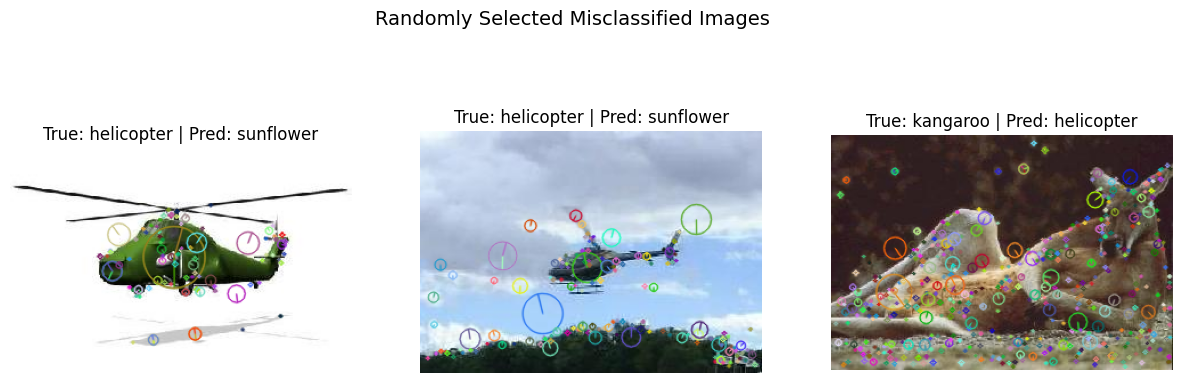

In [63]:

misclassified_indices = np.where(y_pred != y_test)[0]

if len(misclassified_indices) >= 3:
    selected_indices = random.sample(list(misclassified_indices), 3)
else:
    selected_indices = misclassified_indices

fig, axes = plt.subplots(1, len(selected_indices), figsize=(15, 5))

sift = cv2.SIFT_create()

for idx, ax in zip(selected_indices, axes):
    img = cv2.imread(X_test[idx])
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    keypoints, _ = sift.detectAndCompute(gray, None)
    img_with_keypoints = cv2.drawKeypoints(img, keypoints, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

    ax.imshow(cv2.cvtColor(img_with_keypoints, cv2.COLOR_BGR2RGB))
    ax.set_title(f"True: {y_test[idx]} | Pred: {y_pred[idx]}")
    ax.axis("off")

plt.suptitle("Randomly Selected Misclassified Images", fontsize=14)
plt.show()


## **Conclusion**
The **BoVW model** is a useful technique for image classification, particularly when working with traditional machine learning methods. While the accuracy could be improved, the approach successfully demonstrated the concept of converting images into feature histograms for classification. The results also highlight the importance of tuning hyperparameters like **k** and choosing the right distance metric to improve performance.
